![](https://ucarecdn.com/c2edd03c-3664-472b-84f1-1afe67c5bfd3/-/format/jpeg/-/progressive/yes/-/preview/2048x2048/)

## Проект 3. О вкусной и здоровой пище

**Цель проекта**: обнаружить потенциальные накрутки рейтинга ресторанов.

**Данные**: выборка по 40 тыс. ресторанов Европы из датасета TripAdvisor.

**Содержание датасета**:
 * Restaurant_id — идентификационный номер ресторана / сети ресторанов;
 * City — город, в котором находится ресторан;
 * Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
 * Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
 * <span style="color:red">Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);</span>
 * Price Range — диапазон цен в ресторане;
 * Number of Reviews — количество отзывов о ресторане;
 * Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
 * URL_TA — URL страницы ресторана на TripAdvosor;
 * ID_TA — идентификатор ресторана в базе данных TripAdvisor.
 
Целевая переменная: Rating

In [1]:
# Подгружаем библиотеки + определяем ф-ию, с помощью которой мы будем распознавать списки в csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer

# round to two decimal places in python pandas 
pd.options.display.float_format = '{:.2f}'.format


def literal_converter(val):
    '''
    Переводим строковые столбцы, содержащие списки в python-списки.
    В случае пропуска, возвращает пустое значение.
    '''
    try:
        return literal_eval(val)
    except:
        return val
    

df_train = pd.read_csv('main_task.csv', converters={'Cuisine Style': literal_converter, 'Reviews': literal_converter})
df_train['sample'] = 1

df_test  = pd.read_csv('kaggle_task.csv', converters={'Cuisine Style': literal_converter, 'Reviews': literal_converter})
df_test['sample'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

---

### Первичный анализ датасета

In [3]:
# Выборка 10 строк

df.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
49479,id_2746,Amsterdam,[Spanish],2753.00,NaN,2.00,"[[Unexpected Find], [05/25/2014]]",/Restaurant_Review-g188590-d6440857-Reviews-El...,d6440857,1,4.00
39469,id_2597,Berlin,"[Italian, Pizza, European, Mediterranean, Vege...",2599.00,$$ - $$$,48.00,"[[One of the best Neapolitan Pizza, Great spot...",/Restaurant_Review-g187323-d8457398-Reviews-Mo...,d8457398,1,4.00
36599,id_4372,Berlin,,4374.00,NaN,4.00,"[[Turkish Cuisine At Its Best, Get my own beer...",/Restaurant_Review-g187323-d5528029-Reviews-Pa...,d5528029,1,4.50
1461,id_1461,Oporto,"[Mediterranean, European, Portuguese]",624.00,$$ - $$$,54.00,"[[Bonito, agradável, boa cozinha , great res.....",/Restaurant_Review-g189180-d8734320-Reviews-Ka...,d8734320,0,nan
25890,id_12569,Paris,[French],12571.00,$$ - $$$,25.00,"[[Awesome vibe!, We enjoyed our lunch here], [...",/Restaurant_Review-g187147-d6416993-Reviews-Co...,d6416993,1,2.50
24181,id_745,Rome,"[Italian, Gluten Free Options]",746.00,NaN,1441.00,"[[Great lively fish restaurant, Lively restaur...",/Restaurant_Review-g187791-d6419637-Reviews-Po...,d6419637,1,4.00
41697,id_2015,Milan,"[Italian, Steakhouse, Barbecue, European, Fusi...",2017.00,$$ - $$$,1154.00,"[[very interesting, Delicate meat], [06/22/201...",/Restaurant_Review-g187849-d8820594-Reviews-La...,d8820594,1,3.50
47617,id_333,Dublin,"[Irish, Bar, European, Vegetarian Friendly, Ve...",334.00,$$ - $$$,250.00,"[[Friendly barman, Really nice hidden gem in D...",/Restaurant_Review-g186605-d4909573-Reviews-Ho...,d4909573,1,4.00
12084,id_5874,Barcelona,"[International, Mediterranean, Spanish]",5875.00,$$ - $$$,nan,"[[], []]",/Restaurant_Review-g187497-d12554634-Reviews-G...,d12554634,1,4.00
2014,id_2014,Hamburg,"[Swiss, European]",791.00,NaN,9.00,"[[A great invention - Macaron ice cream!, OMG ...",/Restaurant_Review-g187331-d8741635-Reviews-Jo...,d8741635,0,nan


In [4]:
f'Кол-во пустых значений в датасете: \
{round(sum(df.isnull().sum()) / (len(df.columns) * len(df)) * 100, 2)}%'

'Кол-во пустых значений в датасете: 5.56%'

In [5]:
# 2.1 Какие столбцы НЕ содержат пропущенных (None) значений

df.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style            0
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  0
URL_TA                   0
ID_TA                    0
sample                   0
Rating               10000
dtype: int64

In [6]:
# Ищем повторяющиеся записи ресторанов - в кач-ве идентификатора исп. веб-адрес и идентификатор ТА ресторана
# Удаляем найденные дубликаты, оставляя первую запись

display(f"Кол-во повторяющихся строк в датасете: {df.duplicated(subset=['URL_TA', 'ID_TA'], keep='first').sum()}")

df.drop_duplicates(subset=['URL_TA', 'ID_TA'], keep='first', inplace=True, ignore_index=True)

'Кол-во повторяющихся строк в датасете: 37'

In [7]:
# 2.2 В каких столбцах данные хранятся в числовом формате

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49963 entries, 0 to 49962
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      49963 non-null  object 
 1   City               49963 non-null  object 
 2   Cuisine Style      49963 non-null  object 
 3   Ranking            49963 non-null  float64
 4   Price Range        32612 non-null  object 
 5   Number of Reviews  46763 non-null  float64
 6   Reviews            49963 non-null  object 
 7   URL_TA             49963 non-null  object 
 8   ID_TA              49963 non-null  object 
 9   sample             49963 non-null  int64  
 10  Rating             39963 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


---

### Обрабатываем признаки датасета

In [8]:
# 4.3 Среднее кол-во кухонь в ресторане (если данных нет - предполагаем, что одна)

df['Cuisine Style_len'] = df['Cuisine Style'].apply(lambda x: len(x) if isinstance(x, list) else 1)

display(round(df['Cuisine Style_len'].mean(), 1))

2.6

In [9]:
# Создаём отдельное множество значений с типами кухни

cuisines = set()

for c_list in df['Cuisine Style'][~pd.isna(df['Cuisine Style'])]:
    for c in c_list:
        cuisines.add(c)

no_cuisines = len(cuisines)        

display(cuisines, no_cuisines)

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

125

In [10]:
# Создаём из списков Cuisine Style признаки-пустышки
# https://ru.stackoverflow.com/questions/928443/Как-работает-sklearn-preprocessing-multilabelbinarizer

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df['Cuisine Style'].values), index=df.index, columns=mlb.classes_))

In [11]:
# 4.3 Кухня, представленная в наибольшем количестве ресторанов

df.iloc[:, -no_cuisines:].sum().sort_values(ascending=False)

Vegetarian Friendly    14007
European               12553
Mediterranean           7810
Italian                 7430
Vegan Options           5677
                       ...  
Yunnan                     2
Salvadoran                 1
Latvian                    1
Xinjiang                   1
Burmese                    1
Length: 125, dtype: int64

In [12]:
# Смотрим кол-во уникальных городов и нет ли повторов и разных вариантов написания их названий

no_cities = len(df['City'].unique())

display(f"Кол-во уникальных городов: {no_cities}")

df['City'].value_counts(ascending=False)

'Кол-во уникальных городов: 31'

London        7193
Paris         6108
Madrid        3778
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         923
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [13]:
# Дополняем население городов (источник: Википедия - минимальное значение населения в городе, без пригородов)

population = {
            'London': 8908081,
            'Paris': 2241346,
            'Madrid': 3233527,
            'Barcelona': 1620343,
            'Berlin': 3748148,
            'Milan': 1399860,
            'Rome': 2873104,
            'Prague': 1241664,
            'Lisbon': 505526,
            'Vienna': 1749673,
            'Amsterdam': 855965,
            'Brussels': 148873,
            'Hamburg': 1899160,
            'Munich': 1484226,
            'Lyon': 516092,
            'Stockholm': 962154,
            'Budapest': 1729040,
            'Warsaw': 1711324,
            'Dublin': 554554,
            'Copenhagen': 794128,
            'Athens': 664046,
            'Edinburgh': 488050,
            'Zurich': 415215,
            'Oporto': 287591,
            'Geneva': 201818,
            'Krakow': 779115,
            'Oslo': 645701,
            'Helsinki': 635591,
            'Bratislava': 432864,
            'Luxembourg': 119214,
            'Ljubljana': 286745
}

df['Population'] = df['City'].map(population)

df[['City', 'Population']].sample(5)

,City,Population
46123,Geneva,201818
26242,Paris,2241346
22142,Paris,2241346
29188,Paris,2241346
24994,London,8908081


In [14]:
# Делаем признаки-пустышки из признака City

df = pd.concat([df, pd.get_dummies(df['City'])], axis=1)

In [15]:
# Price Range - приводим к единому виду и целочисленному типу данных

pr = {
        '$': 1,
        '$$ - $$$': 2,
        '$$$$': 3
}


df['Price Range'] = df['Price Range'].replace(to_replace=pr)

df['Price Range'].value_counts(ascending=False)

2.00    23020
1.00     7811
3.00     1781
Name: Price Range, dtype: int64

In [16]:
# Ranking - пробуем нормализировать значения в рамках отдельных городов

df['Ranking_norm'] = df.groupby(['City'])['Ranking'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df['Ranking_norm']

0       0.93
1       0.09
2       0.46
3       0.10
4       0.04
        ... 
49958   0.08
49959   0.45
49960   0.67
49961   0.30
49962   0.77
Name: Ranking_norm, Length: 49963, dtype: float64

In [17]:
# Заполняем пропуски Reviews пустыми списками, иначе следующие шаги приводят к ошибкам

df['Reviews'] = df['Reviews'].apply(lambda x: x if isinstance(x, list) else [[], []])

In [18]:
# Number of Reviews - есть ли пропуски там, где есть Reviews? Если да, то дополняем по кол-ву отзывов
# После этого удаляем данный столбец как избыточный (у нас уже есть Number of Reviews)

df['Reviews_len'] = df['Reviews'].apply(lambda x: len(x) if isinstance(x[0], list) else 0)

df['Number of Reviews'].fillna(df['Reviews_len'], inplace=True)

df[['Reviews_len', 'Number of Reviews']]

df.drop(['Reviews_len'], axis=1, inplace=True)

In [19]:
# Обработка NaN для Number of Reviews - отсутствие информации может быть важным признаком!

df['Number of Reviews isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')


# Далее заполняем пропуски 0

df['Number of Reviews'].fillna(0, inplace=True)

In [20]:
# Конвертируем второй список из Reviews в отдельную колонку с типом datetime
# Рассчитываем из неё первую и последнюю дату отзыва и разницу между ними

def list_to_dt(str_list):
    dt_list = []
    try:
        for l in str_list:
            dt_list.append(pd.to_datetime(l, format='%m/%d/%Y'))
        return dt_list
    except:
        return []
    

df['Review Dates'] = df['Reviews'].apply(lambda x: list_to_dt(x[1]))

df['Review Dates Min'] = df['Review Dates'].apply(lambda x: min(x) if len(x) > 0 else None)

df['Review Dates Max'] = df['Review Dates'].apply(lambda x: max(x) if len(x) > 0 else None)

df['Review Dates Var'] = (df['Review Dates Max'] - df['Review Dates Min'])

df['Review Dates Var'] = df['Review Dates Var'].dt.days

In [21]:
# 4.4.a

df['Review Dates Max'].max()

Timestamp('2018-02-26 00:00:00')

In [22]:
# 4.4.b

df['Review Dates Var'][(df['Review Dates Min'] >= '2000-01-01') & (df['Review Dates Max'] >= '2000-01-01')].max()

3296.0

In [23]:
# Попробуем "выцепить" из отзывов ключевые слова, описывающие ресторан и построить из низ доп. признаки

def match_word(wordlist, reviews):
    for word in wordlist:
        for review in reviews:
            if word in review:
                return 1
            else:
                return 0
    

reviews_best = ['excellent', 'wonderful', 'fantastic', 'great', 'delicious', 'best', 'nice', 'superb', 'friendly', 'cosy', 'cozy', 'tasty']
reviews_avg  = ['good', 'decent', 'not bad', 'average', 'not so good']
reviews_poor = ['poor', 'bad', 'worst', 'rip off', 'sucks', 'terrible', 'dirty', 'stink']

df['Reviews_best'] = df['Reviews'].apply(lambda x: match_word(reviews_best, x[0]))
df['Reviews_avg']  = df['Reviews'].apply(lambda x: match_word(reviews_avg,  x[0]))
df['Reviews_poor'] = df['Reviews'].apply(lambda x: match_word(reviews_poor, x[0]))

f"Best: {df['Reviews_best'].sum()}, Average: {df['Reviews_avg'].sum()}, Poor: {df['Reviews_poor'].sum()}"

'Best: 330.0, Average: 2905.0, Poor: 119.0'

---

### Визуальный анализ полученных данных

In [24]:
# Отделяем данные для теста

train_data = df.query('sample == 1').drop(['sample'], axis=1)

test_data = df.query('sample == 0').drop(['sample'], axis=1)

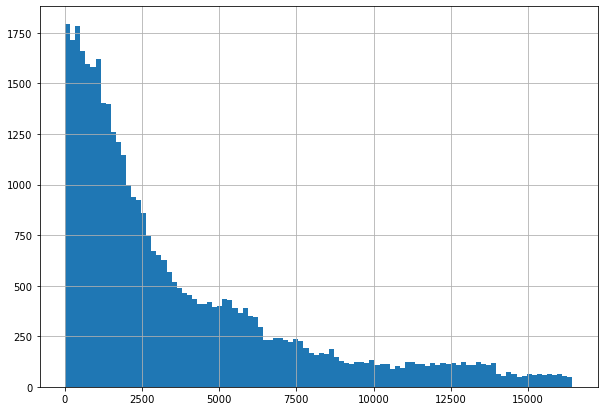

In [25]:
# Много ресторанов не дотягивают и до 2500 места в своем городе

plt.rcParams['figure.figsize'] = (10,7)
train_data['Ranking'].hist(bins=100)

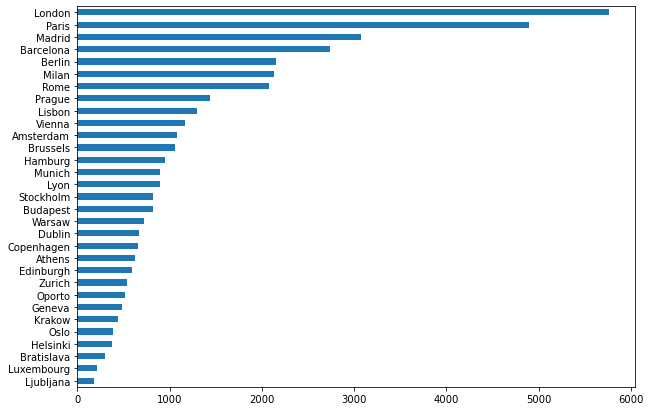

In [26]:
# Распределение по городам

train_data['City'].value_counts(ascending=True).plot(kind='barh')

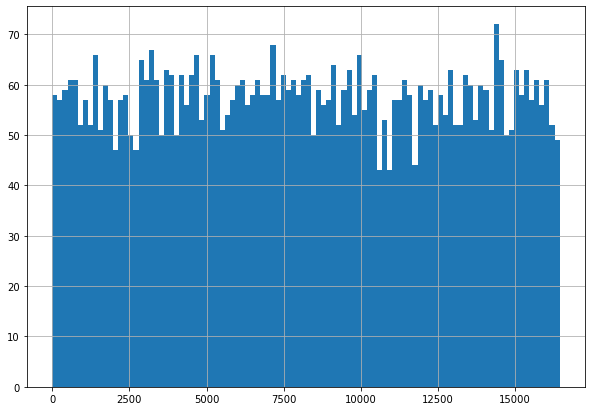

In [27]:
# Пробное распределение ранга в Лондоне, крупнейшом городе выборки

train_data['Ranking'][train_data['City'] =='London'].hist(bins=100)

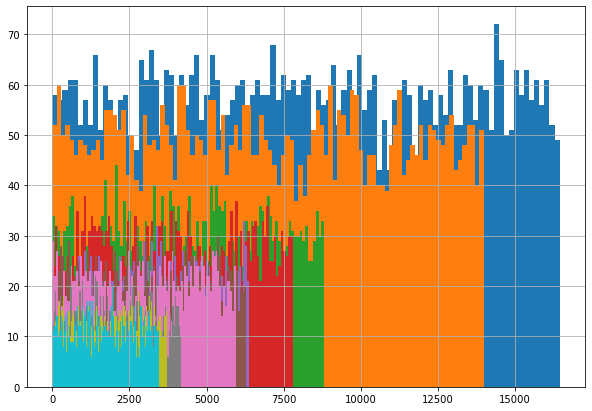

In [28]:
# Посмотрим на топ 10 городов

for x in (train_data['City'].value_counts())[0:10].index:
    train_data['Ranking'][train_data['City'] == x].hist(bins=100)
    
plt.show()

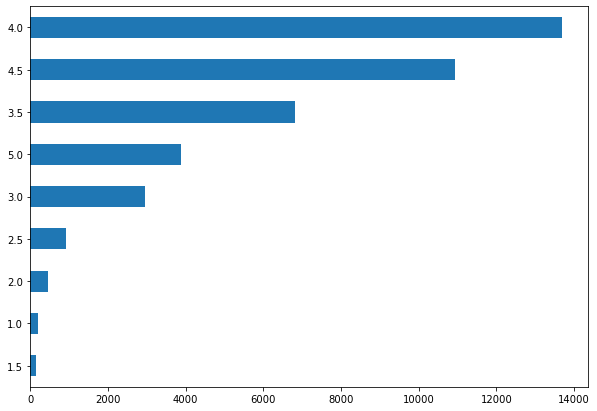

In [29]:
# Распределение целевой переменной Rating

train_data['Rating'].value_counts(ascending=True).plot(kind='barh')

Rating
1.00    AxesSubplot(0.125,0.125;0.775x0.755)
1.50    AxesSubplot(0.125,0.125;0.775x0.755)
2.00    AxesSubplot(0.125,0.125;0.775x0.755)
2.50    AxesSubplot(0.125,0.125;0.775x0.755)
3.00    AxesSubplot(0.125,0.125;0.775x0.755)
3.50    AxesSubplot(0.125,0.125;0.775x0.755)
4.00    AxesSubplot(0.125,0.125;0.775x0.755)
4.50    AxesSubplot(0.125,0.125;0.775x0.755)
5.00    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Ranking, dtype: object

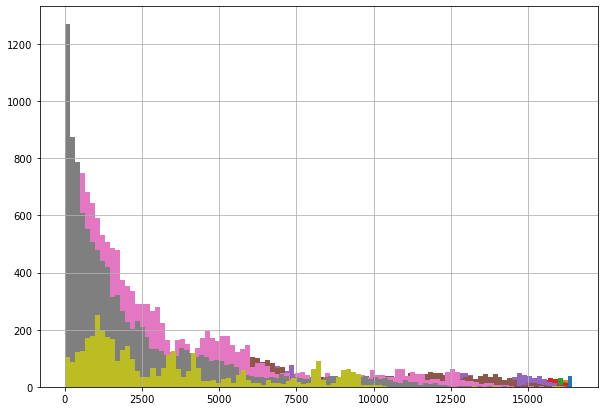

In [30]:
# Соотношение ранга с рейтингом

train_data.groupby(['Rating'])['Ranking'].hist(bins=100)

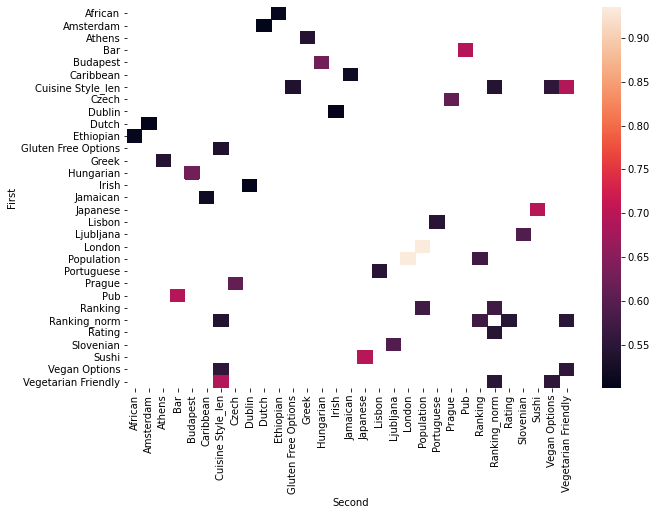

In [31]:
# Корреляция признаков - из-за обилия колонок-пустышек сначала отфильтруем действительно важные
# (с абсолютной корреляцией 0.5 и выше)

# Высчитываем абсолютные величины корреляции
c = train_data.corr().abs()


# Создаём из получившегося датафрейм и переносим данные индекса в столбцы
corr_sort = pd.DataFrame(c.unstack().sort_values(kind="quicksort"))

corr_sort.columns = ['Correlation']
corr_sort['First'] = corr_sort.index.get_level_values(0)
corr_sort['Second'] = corr_sort.index.get_level_values(1)

corr_sort.reset_index(drop=True, inplace=True)


# Убираем корреляцию "самого с собой" и оставляем комбинации с абсолютной корреляцией выше 0.5
cs = corr_sort[
            (corr_sort['First'] != corr_sort['Second']) 
          & (corr_sort['Correlation'] >= 0.5)
]


# Строим график самых высококоррелируемых признаков
sns.heatmap(cs.pivot(index='First'
                    ,columns='Second'
                    ,values='Correlation'))

---

### Финальная подготовка датасетов перед моделированием

#### Тренировочный датасет

In [32]:
# Удалим Ranking, чтобы модель воспользовалась нормализированными значениями
train_data.drop(['Ranking'], axis=1, inplace=True)

# Удаляем из датасета все столбцы типа object (строки и списки) и datetime
train_data = train_data.select_dtypes(exclude=['object', 'datetime64'])

display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39963 entries, 10000 to 49962
Columns: 167 entries, Price Range to Reviews_poor
dtypes: float64(8), int64(127), uint8(32)
memory usage: 42.7 MB


None

In [33]:
# Смотрим какие колонки содержат пропуски, чтобы их дополнить нулями

nan_columns = train_data.isna().sum().sort_values()

display(nan_columns[nan_columns > 0])

for col in list(nan_columns[nan_columns > 0].index):
    train_data[col].fillna(0, inplace=True)

Reviews_best         6465
Reviews_poor         6465
Reviews_avg          6465
Review Dates Var     6465
Price Range         13876
dtype: int64

#### Проверочный датасет

In [34]:
# Удаляем Rating - это предсказываемая величина (также она пуста в данном датасете)
# Удалим Ranking, чтобы модель воспользовалась нормализированными значениями
test_data.drop(['Rating', 'Ranking'], axis=1, inplace=True)

# Сохраняем id ресторанов для выборки
test_ids = test_data['Restaurant_id']

# Удаляем из датасета все столбцы типа object (строки и списки) и datetime
test_data = test_data.select_dtypes(exclude=['object', 'datetime64'])

display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 166 entries, Price Range to Reviews_poor
dtypes: float64(7), int64(127), uint8(32)
memory usage: 10.6 MB


None

In [35]:
# Смотрим какие колонки содержат пропуски, чтобы их дополнить нулями

nan_columns = test_data.isna().sum().sort_values()

display(nan_columns[nan_columns > 0])

for col in list(nan_columns[nan_columns > 0].index):
    test_data[col].fillna(0, inplace=True)

Reviews_best        1643
Reviews_poor        1643
Reviews_avg         1643
Review Dates Var    1643
Price Range         3475
dtype: int64

### Разделение датафрейма

In [36]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = train_data.drop(['Rating'], axis = 1)
y = train_data['Rating']  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [37]:
# проверяем размерность

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 166), (39963, 167), (39963, 166), (29972, 166), (9991, 166))

### Создание, обучение и тестирование модели

In [38]:
# Импортируем необходимые библиотеки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  


# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)


# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)


# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [39]:
# Т.к. рейтинги кратны 0.5 округляем все y_pred до ближайшего 0.5 значения

def round_of_rating(number):
    return round(number * 2) / 2


def round_results(y_pred):
    y_pred_rounded = []

    for y in y_pred:
        y_pred_rounded.append(round_of_rating(y))
    
    return np.array(y_pred_rounded)


# Перезаписываем в y_pred округлённые значения
y_pred = round_results(y_pred)

In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  

print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 3))

MAE: 0.181


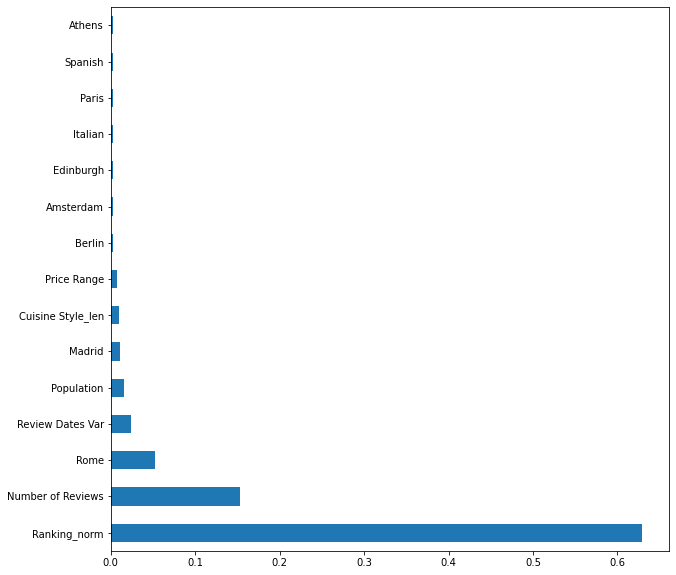

In [41]:
# Выводим самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

---

### Отправка результата

In [42]:
test_data.sample(5)

,Price Range,Number of Reviews,Cuisine Style_len,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,...,Stockholm,Vienna,Warsaw,Zurich,Ranking_norm,Number of Reviews isNAN,Review Dates Var,Reviews_best,Reviews_avg,Reviews_poor
7017,1.00,109.00,3,0,0,0,0,0,0,0,...,0,0,0,0,0.52,0,99.00,0.00,0.00,0.00
716,0.00,4.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0.84,0,295.00,0.00,0.00,0.00
9897,2.00,62.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0.90,0,0.00,0.00,0.00,0.00
9503,1.00,18.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0.52,0,0.00,0.00,0.00,0.00
2524,1.00,16.00,3,0,0,0,0,0,0,0,...,0,0,0,0,0.23,0,28.00,0.00,0.00,0.00


In [43]:
predict_submission = regr.predict(test_data)

# Перезаписываем в y_pred округлённые значения
predict_submission = round_results(predict_submission)

In [44]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4. , 4. ])

In [45]:
sample_submission = pd.DataFrame({'Restaurant_id': test_ids
                                 ,'Rating': predict_submission}
)

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.00
1,id_1,4.50
2,id_2,4.50
3,id_3,4.50
4,id_4,4.50
5,id_5,4.50
6,id_6,1.50
7,id_7,3.00
8,id_8,4.50
9,id_9,4.50
